# Word embeddings

In [1]:
import numpy as np
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

# Computation of Word Embeddings

## Toy corpus

In [2]:
corpus = [
    'she queen',
    'she woman',
    'he king',
    'he man',
    'london uk capital',
    'lisbon portugal capital',   
]

def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)
print(tokenized_corpus)

[['she', 'queen'], ['she', 'woman'], ['he', 'king'], ['he', 'man'], ['london', 'uk', 'capital'], ['lisbon', 'portugal', 'capital']]


## Vocabulary

In [3]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)
print(word2idx)

{'she': 0, 'queen': 1, 'woman': 2, 'he': 3, 'king': 4, 'man': 5, 'london': 6, 'uk': 7, 'capital': 8, 'lisbon': 9, 'portugal': 10}


## Context windows

In [4]:
window_size = 2
idx_pairs = []

# for each sentence
for sentence in tokenized_corpus:
    sentence_indices = [word2idx[word] for word in sentence]
    print(sentence)

    # for each word, treated as center word
    for center_word_pos in range(len(sentence_indices)):

        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make sure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(sentence_indices) or center_word_pos == context_word_pos:
                continue

            context_word_idx = sentence_indices[context_word_pos]

            print("POS:  ",idx2word[sentence_indices[center_word_pos]], " ", idx2word[context_word_idx])
            idx_pairs.append((sentence_indices[center_word_pos], context_word_idx, 1))

## Negative sampling
for word1 in vocabulary:
    for word2 in vocabulary:
        if((word2idx[word1], word2idx[word2], 1) not in idx_pairs):
            print("NEG:  ",word1, " ", word2)
            idx_pairs.append((word2idx[word1], word2idx[word2], 0))

idx_pairs = np.array(idx_pairs)


['she', 'queen']
POS:   she   queen
POS:   queen   she
['she', 'woman']
POS:   she   woman
POS:   woman   she
['he', 'king']
POS:   he   king
POS:   king   he
['he', 'man']
POS:   he   man
POS:   man   he
['london', 'uk', 'capital']
POS:   london   uk
POS:   london   capital
POS:   uk   london
POS:   uk   capital
POS:   capital   london
POS:   capital   uk
['lisbon', 'portugal', 'capital']
POS:   lisbon   portugal
POS:   lisbon   capital
POS:   portugal   lisbon
POS:   portugal   capital
POS:   capital   lisbon
POS:   capital   portugal
NEG:   she   she
NEG:   she   he
NEG:   she   king
NEG:   she   man
NEG:   she   london
NEG:   she   uk
NEG:   she   capital
NEG:   she   lisbon
NEG:   she   portugal
NEG:   queen   queen
NEG:   queen   woman
NEG:   queen   he
NEG:   queen   king
NEG:   queen   man
NEG:   queen   london
NEG:   queen   uk
NEG:   queen   capital
NEG:   queen   lisbon
NEG:   queen   portugal
NEG:   woman   queen
NEG:   woman   woman
NEG:   woman   he
NEG:   woman   king
NE

## Learning cycle

In [20]:
import torch.nn.functional as F

embedding_dims = 4
num_epochs = 100
learning_rate = 0.1

Wi = torch.randn(embedding_dims, vocabulary_size, requires_grad=True).float()
Wo = torch.randn(vocabulary_size, embedding_dims, requires_grad=True).float()

logreg = torch.nn.Sigmoid()
loss = torch.nn.BCELoss()
for epo in range(num_epochs):
    train_loss = 0
    idx_pairs = np.random.permutation(idx_pairs)
    for word_i, word_o, label in idx_pairs:
        
        # Get the current word-pair label
        y_label = torch.from_numpy(np.array(label)).float()
        
        # Compute the condiditional probablity between the two words
        z = torch.dot(Wi[:,word_i], Wo[word_o,:])
        p_wo_wi = logreg(z)

        # Compute the error with the positive/negative label
        output = loss(p_wo_wi, y_label)
        train_loss += output

        # Propagate the error backward and update the parameters
        output.backward()
        Wi[:,word_i].data -= learning_rate * Wi.grad.data[:,word_i]
        Wo[word_o,:].data -= learning_rate * Wo.grad.data[word_o,:]

        # Reset
        Wi.grad.data.zero_()
        Wo.grad.data.zero_()
                
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {train_loss/len(idx_pairs)}')

w2v = (Wi.T+Wo)/2

Loss at epo 0: 0.949459969997406
Loss at epo 10: 0.24348440766334534
Loss at epo 20: 0.1447778046131134
Loss at epo 30: 0.1040395200252533
Loss at epo 40: 0.07848739624023438
Loss at epo 50: 0.061444010585546494
Loss at epo 60: 0.047892212867736816
Loss at epo 70: 0.03320643678307533
Loss at epo 80: 0.022616716101765633
Loss at epo 90: 0.016512403264641762


## Visualize the embeddings

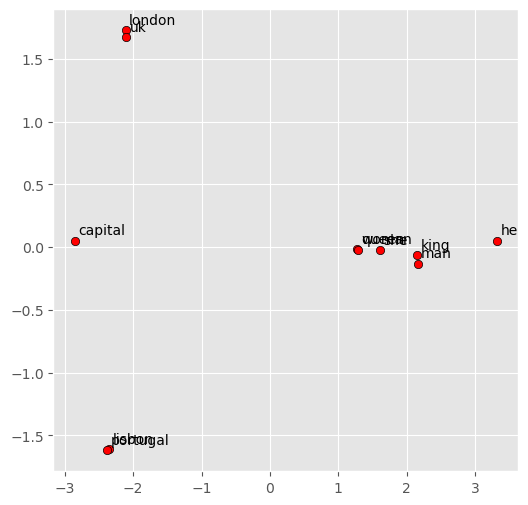

In [21]:
display_scatterplot(w2v.detach().numpy(), vocabulary)


In [7]:
w2v

tensor([[-1.8888, -1.6999,  0.0626,  1.6125],
        [-1.5441, -1.4469, -0.2924,  1.4700],
        [-1.5620, -1.5056, -0.5039,  1.4748],
        [-1.8718, -0.5922,  1.6934, -1.7281],
        [-1.2090, -0.2657,  1.4139, -1.5435],
        [-1.1449, -0.5031,  1.3589, -1.7219],
        [ 2.7115, -0.4753, -1.6043,  0.4311],
        [ 2.6509, -0.3622, -1.6364,  0.4851],
        [ 2.1323,  1.2614, -0.8913,  0.0302],
        [ 1.5068,  2.5092, -0.4127, -0.6349],
        [ 1.5161,  2.5851, -0.3565, -0.5469]], grad_fn=<DivBackward0>)

# Pre-trained Word Embeddings

In [8]:
import gensim.downloader as api
import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load Word2Vec trained on Google News data
wv = api.load('word2vec-google-news-300')

## Word Vectors

In [9]:
# Import NumPy
import numpy as np

# Import PCA from scikit-learn
from sklearn.decomposition import PCA

# Import PCA from scikit-learn
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

# Import Gensim for the word embeddings
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

for i, word in enumerate(wv.key_to_index):
    if i == 10:
        break
    print(word)


</s>
in
for
that
is
on
##
The
with
said


In [10]:
vec_king = wv['king']
print(vec_king)

[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582031e-02
  1.85546875e-01  4.47265

## Words Similarity

In [11]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


In [12]:
print(wv.most_similar(positive=['car', 'batman'], topn=5))

[('Batmobile', 0.5841229557991028), ('vehicle', 0.5716538429260254), ('batmobile', 0.5692458152770996), ('suv', 0.5399793982505798), ('scooter', 0.539139986038208)]


## Word Analogies


In [13]:
def analogy(x1, x2, y1):
    result = wv.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [14]:
analogy('japan', 'japanese', 'brazil')

'brazilian'

In [15]:
analogy('queen', 'king', 'woman')

'man'

In [16]:
analogy('good', 'fantastic', 'bad')

'horrible'

## Visualization

In [17]:
def display_pca_scatterplot(model, words):

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
        
def display_closestwords(model, word):
    
    # get close words
    a = model.similar_by_word(word)
    close_words = [w for (w,s) in a]
    close_words.append(word)
    display_pca_scatterplot(model, close_words)


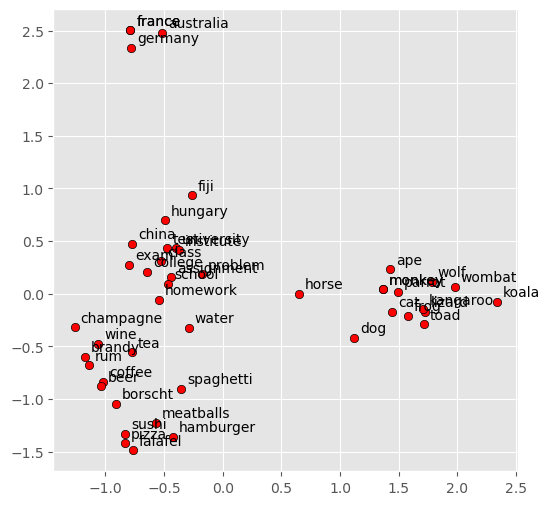

In [18]:
display_pca_scatterplot(wv, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'france', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

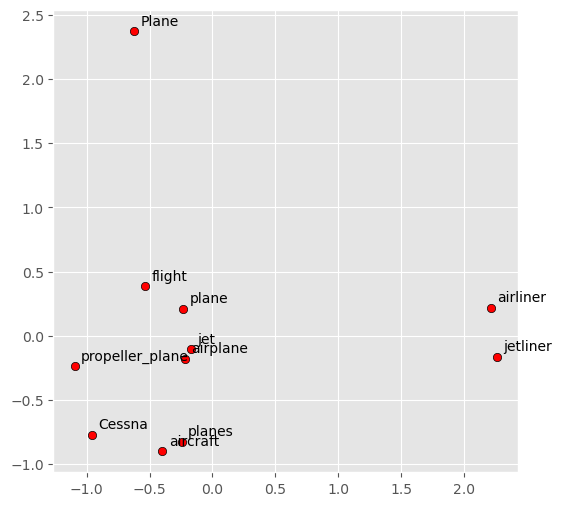

In [19]:
a = display_closestwords(wv, 'plane')

## More

 - Word Embeddings for noisy text https://fasttext.cc/docs/en/english-vectors.html


 - Diachronic Word Embeddings https://nlp.stanford.edu/projects/histwords/


 - Sentence Embeddings https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
